<a href="https://colab.research.google.com/github/wdconinc/parity-jupyter-notebooks/blob/master/FindingBestRegressionSetsInSinglePassAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding Best Linear Regresssion Sets In Single Pass Analysis

## Preamble

In [0]:
import numpy as np
import matplotlib.pyplot as plt

## Create Test Data Set With Random Correlations

### Choose Dimensionality

In [2]:
np.random.seed(0)

# number of dependent variables
M = np.random.randint(10, 15)
# number of independent variables
N = np.random.randint(10, 15)
# number of larger correlations between dependent and independent
K = np.random.randint(2, min(M,N))

print("Using %d independent variables with %d large correlations, %d dependent variables" % (N,K,M))

Using 10 independent variables with 5 large correlations, 14 dependent variables


### Create Correlation Matrix

If we start from $Z$, a column of independently and normally distributed random variables, then we can construct $X$, a column of correlated and normally distributed random variables with covariance matrix $\Sigma$ as follows:
- find the Cholesky decomposition of $\Sigma$ (positive-definite) into an upper triangular $C$:
$$ \Sigma = C^T C $$
- apply Cholesky matrix to $Z$:
$$ X = C^T Z $$

Reference: http://www.columbia.edu/~mh2078/MonteCarlo/MCS_Generate_RVars.pdf

We can also write $\Sigma$ in terms of the matrix of correlation coefficients $\mathrm{Corr}[X]$, where the diagonal elements will be ones and the off-diagonal elements between -1 and +1:
\begin{align}
\Sigma & = Cov[X] \\ 
& = Diag[Var(X)]^\frac{1}{2} \, Corr[X] \, Diag[Var(X)]^\frac{1}{2} \\
& = Diag[\Sigma]^\frac{1}{2} \, Corr[X] \, Diag[\Sigma]^\frac{1}{2} \\
& = \sigma \, R \, \sigma
\end{align}

We will use the [covariance matrix in block form](https://en.wikipedia.org/wiki/Covariance_matrix#Block_matrices).
$$ \Sigma = \Big[ \begin{array}{cc} \Sigma_{XX} & \Sigma_{XY} \\ \Sigma_{YX} & \Sigma_{YY} \end{array}\Big] $$
and
$$ R = \Big[ \begin{array}{cc} R_{XX} & R_{XY} \\ R_{YX} & R_{YY} \end{array}\Big] $$
with $X$ the so-called independent variables and $Y$ the so-called dependent variables.

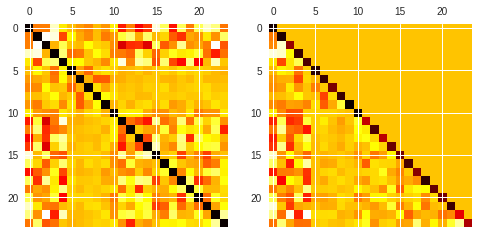

In [3]:
# Construct diagonal of Sigma
diag0 = np.diag(0.1 + np.random.randn(M + N) * 0.01)

# Construct random correlation matrix
corr0 = np.random.randn(N+M, N+M) * 0.01 # normal at 1% level
corr0[:N,:N] = np.random.randn(N, N) * 0.1 # normal at 10% level
corr0[N:,N:] = np.random.randn(M, M) * 0.1 # normal at 10% level
corr0[:K,:K] = (np.random.rand(K, K) * 2 - 1) # uniform between -1 and +1
corr0[:K,N:] = (np.random.rand(K, M) * 2 - 1) # uniform between -1 and +1
np.fill_diagonal(corr0, 1) # diagonal is 1
corr0 = (corr0 + corr0.T) / 2 # symmetrize
corr0 = corr0 @ corr0.T # positive definite

# Make sure correlation matrix is normalized
norm0 = np.diag(np.sqrt(np.diag(corr0))**-1)
corr0 = norm0 @ corr0 @ norm0
corr0 = (corr0 + corr0.T) / 2.0

# Determine covariance
cov0 = diag0 @ corr0 @ diag0

# Plot correlation matrix
fig,ax = plt.subplots(1,2)
ax[0].matshow(corr0, cmap = "hot_r")

# Cholesky decomposition (returns *lower* triangular matrix)
C = np.linalg.cholesky(cov0)
ax[1].matshow(C, cmap = "hot_r") 
np.testing.assert_allclose(C @ C.T, cov0)

### Create Correlated Data Set

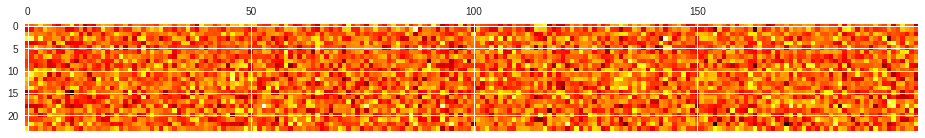

In [4]:
# Number of measurements
n = 1000000

# Create X and Y
Z = np.random.randn(N + M, n)
XY = C @ Z
X = XY[:N]
Y = XY[N:]

# Plot some data
plt.matshow(XY[:,:200], cmap = "hot_r");

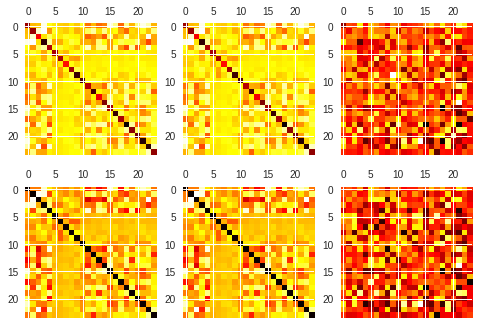

In [5]:
cov = np.cov(XY)
corr = np.corrcoef(XY)

fig, ax = plt.subplots(2,3)
ax[0,0].matshow(cov, cmap = "hot_r")
ax[0,1].matshow(cov0, cmap = "hot_r")
ax[0,2].matshow(cov0 - cov, cmap = "hot_r")
np.testing.assert_allclose(cov0, cov, atol = 0.2 * np.average(cov))

ax[1,0].matshow(corr, cmap = "hot_r")
ax[1,1].matshow(corr0, cmap = "hot_r")
ax[1,2].matshow(corr0 - corr, cmap = "hot_r")
np.testing.assert_allclose(corr0, corr, atol = 0.2 * np.average(corr))

## Determine Summary Statistics Before Correction

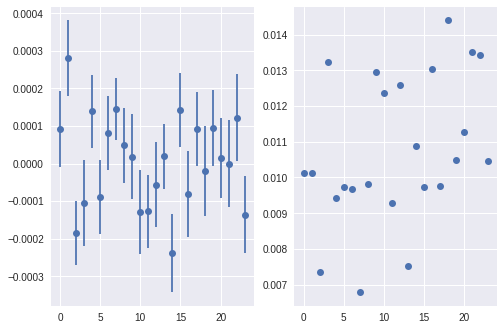

In [7]:
means = np.mean(XY, axis = 1)
vars = np.var(XY, axis = 1)
dmeans = np.sqrt(vars) / np.sqrt(n)

# Plot means and variances
fig,ax = plt.subplots(1,2)
ax[0].errorbar(range(len(means)), means, dmeans, fmt = 'o')
ax[1].errorbar(range(len(vars)), vars, fmt = 'o')
plt.show()

## Calculate Corrected Values

#### Model
We hypothesize that the observed values for $Y$ are related to the observed values for $X$ by
$$ Y = Y' + X A_{XY} + \epsilon $$
in the presence of the normally distribute noise $\epsilon = \mathcal{N}(0, \sigma_Y^2 I)$. 

We wish to determine the underlying $E[Y']$ and $Cov[XY']$ from the observed $E[Y]$ and $Cov[XY]$. We wish to determine an estimator $\hat{A}_{XY}$ and a statistical test to determine how many parameters $p$ in $X$ should be included (i.e. for which $p$ is the null hypothesis of the observed dependence allowed for $p-1$ parameters excluded at a certain probability).

#### Covariance and Correlation Matrices
The regression corrections are determined for the observed correlation matrix $R$, covariance matrix $\Sigma$, and diagonal matrix $\sigma$ of standard deviations.

$$ \Sigma = \Big[ \begin{array}{cc} \Sigma_{XX} & \Sigma_{XY} \\ \Sigma_{YX} & \Sigma_{YY} \end{array}\Big] = \Big[ \begin{array}{cc} \sigma_X & 0 \\ 0 & \sigma_Y\end{array} \Big] \Big[ \begin{array}{cc} R_{XX} & R_{XY} \\ R_{YX} & R_{YY} \end{array}\Big] \Big[ \begin{array}{cc} \sigma_X & 0 \\ 0 & \sigma_Y\end{array} \Big] = \sigma R \sigma $$

with the indepedent and dependent variable covariance and correlation matrices
$$ \Sigma_{XX} = \sigma_X R_{XX} \sigma_X $$
$$ \Sigma_{XY} = \sigma_X R_{XY} \sigma_Y $$
$$ \Sigma_{YY} = \sigma_Y R_{YY} \sigma_Y $$


#### Removing Correlations Between $Y'$ and $X$
We wish to determine $A_{XY}$ such that the corrected dependent variables
$$ Y' = Y - X A_{XY} $$
are uncorrelated with $X$. This occurs when their cross covariance matrix is zero:
$$ Cov[X,Y'] = E[(X - E[X])(Y' - E[Y'])] = 0 $$

We can expand this and solve for $A_{XY}$:
\begin{align}
E[(X - E[X])(Y - XA_{XY} - E[Y] + E[X] A_{XY})] & = 0 \\
E[(X - E[X])(Y - E[Y])] - E[(X - E[X])(X - E[X])] A_{XY} & = 0 \\
Cov[X,Y] - Var[X] A_{XY} & = 0 \\
\Sigma_{XY} - \Sigma_{XX} A_{XY} & = 0
\end{align}

The solution occurs for a specific $\hat{A}_{XY}$:
$$ \hat{A}_{XY} = \Sigma_{XX}^{-1} \Sigma_{XY} $$
which exists when the inverse of $\Sigma_{XX}$ exists, or when there are no linearly related variables in the set of independent variables $X$.

We can write this in terms of correlation matrices as well (this is the notation that is used in Qweak linear regression):
$$ \hat{A}_{XY} = \Sigma_{XX}^{-1} \Sigma_{XY} = (\sigma_X^{-1} R_{XX}^{-1} \sigma_X^{-1}) (\sigma_X R_{XY} \sigma_Y) =\sigma_X^{-1} R_{XX}^{-1} R_{XY} \sigma_Y $$

In this case the mean and variance just become
\begin{align}
E[Y'] & = E[Y] - E[X] \hat{A}_{XY} \\
Var[Y'] & = E[(Y' - E[Y'])^2] \\ & = E[(Y - X \hat{A}_{XY} - E[Y] + E[X] \hat{A}_{XY})^2] \\ & = E[(Y - E[Y]) - (X - E[X])\hat{A}_{XY})^2] \\ & = Cov[Y] + Cov[X\hat{A}_{XY}] - 2 Cov[X,Y] \hat{A}_{XY} \\ & = Cov[Y] + \hat{A}_{YX} Cov[X] \hat{A}_{XY} - 2 Cov[X,Y] \hat{A}_{XY} \\
& = \Sigma_{YY} + \hat{A}_{YX} \Sigma_{XX} \hat{A}_{XY} - 2 \Sigma_{YX} \hat{A}_{XY}
\end{align}


#### Uncertainty on Regression Coefficients
To obtain the uncertainty on the regression coefficients, we introduce a normally distributed noise variable $\epsilon = \mathcal{N}(0,\sigma^2)$ on $Y$ such that:
$$ Y = X A_{XY} + \epsilon = X A_{XY} +\mathcal{N}(0,\sigma_Y^2) $$

If we write
\begin{align}
\hat{A}_{XY} & = \Sigma_{XX}^{-1} \Sigma_{XY} \\
& = E[(X^T X)^{-1}] E[(X^T Y)] \\
& = E[(X^T X)^{-1}] E[(X^T (X A_{XY} + \epsilon)] \\
& = A_{XY} + E[(X^T X)^{-1}] E[(X^T e)] \\
& = \mathcal{N}(A_{XY}, E[(X^T X)^{-1}] E[(X^T \sigma_Y^2)]
\end{align}

This then becomes, on the diagonal:
$$ \Delta A_{XY} = \Sigma_{XX}^{-1}  $$ FIXME

Somehow LinRegBlue claims that the uncertainty on $A_{XY}$ is given by
$$ \Delta A_{XY} = \sigma_X^{-1} R_{XX}^{-1} \sigma_{Y'} / \sqrt{ndof} $$

FIXME: I think there should be an entire $M \times M$ covariance matrix for the $M$ sensitivities in $A_{XY}$ for each of the $N$ dependent variables $Y$.

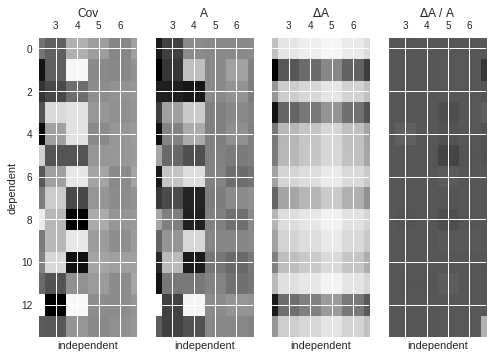

In [8]:
# Independent covariances and standard deviations
Sigma_XX = cov[:N,:N]
Sigma_X = np.diag(np.sqrt(np.diag(Sigma_XX)))
Sigma_XX_Inv = np.linalg.inv(Sigma_XX)
Sigma_X_Inv = np.linalg.inv(Sigma_X)
R_XX = corr[:N,:N]
R_XX_Inv = np.linalg.inv(R_XX)
np.testing.assert_allclose(Sigma_X @ R_XX @ Sigma_X, Sigma_XX)

# Dependent covariances and standard deviations
Sigma_YY = cov[N:,N:]
Sigma_Y = np.diag(np.sqrt(np.diag(Sigma_YY)))
Sigma_Y_Inv = np.linalg.inv(Sigma_Y)
R_YY = corr[N:,N:]
np.testing.assert_allclose(Sigma_Y @ R_YY @ Sigma_Y, Sigma_YY)

# Cross correlations
Sigma_XY = cov[:N,N:]
R_XY = corr[:N,N:]
np.testing.assert_allclose(Sigma_X @ R_XY @ Sigma_Y, Sigma_XY)

# Sensitivities
A_XY = Sigma_XX_Inv @ Sigma_XY
A_YX = A_XY.T

# Uncertainties
Sigma_YpYp = Sigma_Y @ Sigma_Y + A_YX @ Sigma_XX @ A_XY - 2 * A_YX @ Sigma_XY
sigma_Yp = np.sqrt(np.diag(Sigma_YpYp))
ndof = n - N - 1
# FIXME
dA_XY = np.outer(np.sqrt(np.diag(R_XX_Inv)) * np.diag(Sigma_X_Inv), 1 / (sigma_Yp * np.sqrt(ndof)))
dA_YX = dA_XY.T

# Plot sensitivities
fig, ax = plt.subplots(1,4,sharey = True)
ax[0].matshow(Sigma_XY.T)
ax[0].set_xlabel("independent")
ax[0].set_ylabel("dependent")
ax[0].set_title("Cov")
ax[1].matshow(A_YX)
ax[1].set_xlabel("independent")
ax[1].set_title("A")
ax[2].matshow(dA_YX)
ax[2].set_xlabel("independent")
ax[2].set_title("$\\Delta$A")
ax[3].matshow(dA_YX / A_YX)
ax[3].set_xlabel("independent")
ax[3].set_title("$\\Delta$A / A")
plt.show();

In [0]:
# Setup correction on copy
XY_c = XY.copy()
X_c = XY_c[:N]
Y_c = XY_c[N:]

# Apply correction
Y_c -= A_YX @ X_c

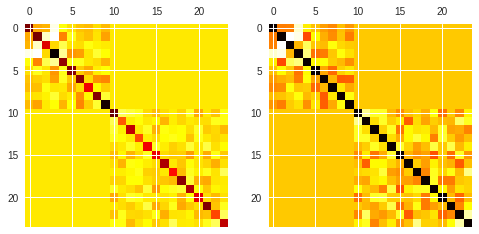

In [10]:
# Calculate correlations
cov_c = np.cov(XY_c)
corr_c = np.corrcoef(XY_c)

# Plot
fig, ax = plt.subplots(1,2)
ax[0].matshow(cov_c, cmap = "hot_r")
ax[1].matshow(corr_c, cmap = "hot_r")

# assert zero blocks (atol since rtol useless when second argument is zero)
np.testing.assert_allclose(cov_c[:N,N:], 0, atol = 1e-7)
np.testing.assert_allclose(cov_c[N:,:N], 0, atol = 1e-7)

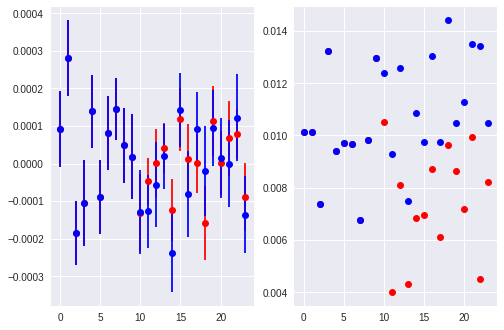

In [14]:
# Summary statistics
means_c = np.mean(XY_c, axis = 1)
vars_c = np.var(XY_c, axis = 1)
dmeans_c = np.sqrt(vars_c) / np.sqrt(n)

# Plot means and variances
fig,ax = plt.subplots(1,2)
ax[0].errorbar(range(len(means_c)), means_c, dmeans_c, fmt = 'or')
ax[0].errorbar(range(len(means)), means, dmeans, fmt = 'ob')
ax[1].errorbar(range(len(vars_c)), vars_c, fmt = 'or')
ax[1].errorbar(range(len(vars)), vars, fmt = 'ob')
plt.show()

#### Testing for Agreement With Matrix Multiplication

In [0]:
# correction of the means
np.testing.assert_allclose(means[N:] - A_YX @ means[:N], means_c[N:])

In [0]:
# correction of the new covariances
np.testing.assert_allclose(cov[N:,N:] + A_YX @ cov[:N,:N] @ A_XY - 2 * A_YX @ cov[:N,N:], cov_c[N:,N:])

In [0]:
# correction of the new variances
np.testing.assert_allclose(sigma_Yp**2, vars_c[N:], rtol = 1e-4)